In [1]:
import math
import numpy as np

import drawsvg as draw
from drawsvg import Drawing
from hyperbolic import euclid, util
from hyperbolic.poincare import *
from hyperbolic.poincare.util import (
    radial_euclid_to_poincare, radial_poincare_to_euclid,
    poincare_to_euclid_factor, triangle_side_for_angles,
)
import hyperbolic.tiles as htiles

In [2]:
def draw_tiles(drawing, tiles):
    for tile in tiles:
        d.draw(tile, hwidth=0.02, fill='white')
    for tile in tiles:
        d.draw(tile, draw_verts=True, hradius=0.15, hwidth=0.02,
                     fill='black', opacity=0.6)

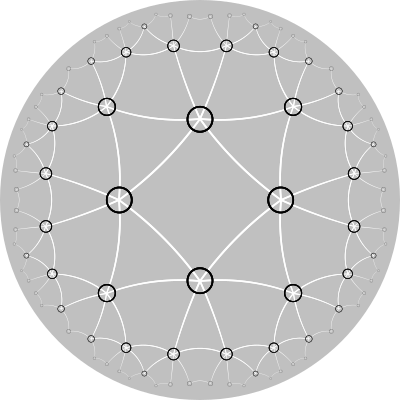

In [3]:
p1 = 4
p2 = 3
q = 3

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phi_sum = math.pi*2/q
r1 = triangle_side_for_angles(theta1/2, phi_sum/2, theta2/2)
r2 = triangle_side_for_angles(theta2/2, phi_sum/2, theta1/2)

t_gen1 = htiles.TileGen.make_regular(p1, hr=r1, skip=1)
t_gen2 = htiles.TileGen.make_regular(p2, hr=r2, skip=1)

t_layout = htiles.TileLayout()
t_layout.add_generator(t_gen1, (1,)*p1)
t_layout.add_generator(t_gen2, (0,)*p2)
start_tile = t_layout.default_start_tile(rotate_deg=90)

tiles = t_layout.tile_plane(start_tile, depth=4)

d = Drawing(2, 2, origin='center')
d.draw(euclid.Circle(0, 0, 1), fill='silver')
draw_tiles(d, tiles)

d.set_render_size(w=400)
d.save_svg('images/tileTriangleSquare.svg')
d

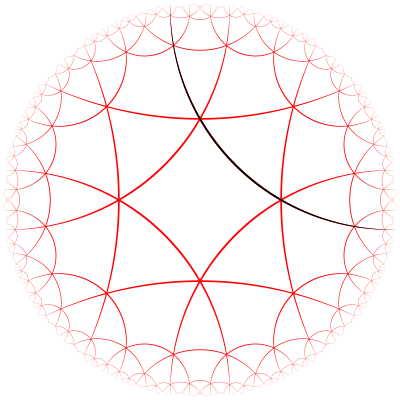

In [4]:
p1 = 4
p2 = 3
q = 3
rotate = 0

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phi_sum = math.pi*2/q
r1 = triangle_side_for_angles(theta1/2, phi_sum/2, theta2/2)
r2 = triangle_side_for_angles(theta2/2, phi_sum/2, theta1/2)

t_gen1 = htiles.TileGen.make_regular(p1, hr=r1, skip=1)
t_gen2 = htiles.TileGen.make_regular(p2, hr=r2, skip=1)

t_layout = htiles.TileLayout()
t_layout.add_generator(t_gen1, (1,)*p1)
t_layout.add_generator(t_gen2, (0,)*p2, htiles.TileDecoratorNull())
start_tile = t_layout.default_start_tile(rotate_deg=rotate)

t1 = start_tile
t2 = t_layout.place_tile(t1.sides[-1])
t3 = t_layout.place_tile(t2.sides[-1])
point_base = t3.vertices[-1]
points = [Transform.rotation(deg=-i*360/p1).apply_to_point(point_base)
          for i in range(p1)]
vertices = start_tile.vertices
edges = []
for i, point in enumerate(points):
    v1 = vertices[i]
    v2 = vertices[(i+1)%p1]
    edge = Hypercycle.from_points(*v1, *v2, *point, segment=True, exclude_mid=True)
    edges.append(edge)
decorate_poly = Polygon(edges=edges, vertices=vertices)
decorator1 = htiles.TileDecoratorPolygons(decorate_poly)
t_layout.set_decorator(decorator1, 0)

start_tile = t_layout.default_start_tile(rotate_deg=rotate)
tiles = t_layout.tile_plane(start_tile, depth=6)

d = Drawing(2, 2, origin='center')
#d.draw(euclid.Circle(0, 0, 1), fill='silver')
for tile in tiles:
    d.draw(tile, hwidth=0.02, fill='red')
tiles[0].decorator = None
d.draw(Hypercycle.from_points(
            *tiles[0].vertices[0], *tiles[0].vertices[1], *point_base
        ), hwidth=0.02, fill='black')

d.set_render_size(w=400)
d.save_svg('images/escherOverlay.svg')
d

In [5]:
class TileDecoratorFish(htiles.TileDecoratorPolygons):
    def __init__(self, p1=4, p2=3, q=3):
        theta1, theta2 = math.pi*2/p1, math.pi*2/p2
        phi_sum = math.pi*2/q
        r1 = triangle_side_for_angles(theta1/2, phi_sum/2, theta2/2)
        r2 = triangle_side_for_angles(theta2/2, phi_sum/2, theta1/2)
        t_gen1 = htiles.TileGen.make_regular(p1, hr=r1)
        t_gen2 = htiles.TileGen.make_regular(p2, hr=r2)

        t1 = t_gen1.centered_tile()
        t2 = t_gen2.placed_against_tile(t1, side=-1)
        t3 = t_gen1.placed_against_tile(t2, side=-1)
        point_base = t3.vertices[-1]
        points = [Transform.rotation(deg=-i*360/p1).apply_to_point(point_base)
                  for i in range(p1)]
        vertices = t1.vertices
        
        edges = []
        for i, point in enumerate(points):
            v1 = vertices[i]
            v2 = vertices[(i+1)%p1]
            edge = Hypercycle.from_points(*v1, *v2, *point, segment=True, exclude_mid=True)
            edges.append(edge)
        edge_poly = Polygon(edges=edges, vertices=vertices)

        origin = Point(0,0)
        corner = Point.from_h_polar(r1, theta=0)
        corner2 = Transform.rotation(rad=-theta1).apply_to_point(corner)
        center = Point.from_h_polar(r2, theta=-math.pi+phi_sum/2)
        center = Transform.translation(corner).apply_to_point(center)
        poly = Polygon.from_vertices((origin, corner, center, corner2))
        desc = poly.make_restore_points()
        descs = [Transform.rotation(deg=-i*360/p1).apply_to_list(desc)
                 for i in range(p1)]

        super().__init__(edge_poly, poly_descs=descs)
        self.p1 = p1
        self.p2 = p2
        self.colors = ['#ffbf00', 'green', 'red', 'blue', 'gray', 'brown']
    def to_drawables(self, tile=None, layer=0, **kwargs):
        if tile is None:
            trans = Transform.identity()
            codes = range(self.p1)
        else:
            trans = tile.trans
            codes = [side.code[1] for side in tile.sides]
        polys = [Polygon.from_restore_points(trans.apply_to_list(desc))
                 for desc in self.poly_descs]
        ds = []
        if layer == 0:
            for i, poly in enumerate(polys[1:]):
                color = self.colors[codes[i]]
                d = poly.to_drawables(fill=color, opacity=0.5, **kwargs)
                ds.extend(d)
        if layer == 1:
            d_last = polys[0].to_drawables(hwidth=0.03, fill='white', **kwargs)
            ds.extend(d_last)
        if layer == 2:
            for i, poly in enumerate(polys[1:]):
                d = poly.to_drawables(hwidth=0.01, fill='black', **kwargs)
                ds.extend(d)
        return ds

In [6]:
class TileLayoutFish(htiles.TileLayout):
    def calc_gen_index(self, code):
        ''' Override in subclass to control which type of tile to place '''
        if code == 0 or code == 1:
                return code
        index, color, cw = code
        return index
    def calc_tile_touch_side(self, code, gen_index):
        ''' Override in subclass to control tile orientation '''
        return 0
    def calc_side_codes(self, code, gen_index, touch_side, default_codes):
        ''' Override in subclass to control tile side codes '''
        p = len(default_codes)
        if code == 0 or code == 1:
            c = (code+1) % 2
            if p % 2 == 0:
                return ((c,0,1),(c,1,0))*(p//2)
            else:
                return ((c,0,1),(c,1,2),(c,2,0))*(p//3)
        index, color, other_color = code
        c = (index+1) % 2
        # 0=yellow, 1=green, 2=red, 3=blue
        if index == 1:
            new_colors = {
                (0,1): (0,2,3),
                (1,0): (1,3,2),
                (0,2): (0,3,1),
                (2,0): (2,1,3),
                (0,3): (0,1,2),
                (3,0): (3,2,1),
                (1,2): (1,0,3),
                (2,1): (2,3,0),
                (1,3): (1,2,0),
                (3,1): (3,0,2),
                (2,3): (2,0,1),
                (3,2): (3,1,0),
            }[(color, other_color)] * 10
        elif index == 0:
            new_colors = {
                (0,1): (0,3,0,3),  # 0,1,2
                (1,2): (1,3,1,3),
                (2,0): (2,3,2,3),
                (0,2): (0,1,0,1),  # 0,2,3
                (2,3): (2,1,2,1),
                (3,0): (3,1,3,1),
                (0,3): (0,2,0,2),  # 0,3,1
                (3,1): (3,2,3,2),
                (1,0): (1,2,1,2),
                (1,3): (1,0,1,0),  # 1,3,2
                (3,2): (3,0,3,0),
                (2,1): (2,0,2,0),
            }[(color, other_color)] * 10
        else:
            assert False
        new_colors = new_colors[:p]
        codes = [(c,new_color,new_colors[(i+1)%len(new_colors)])
                for i, new_color in enumerate(new_colors)]
        return codes

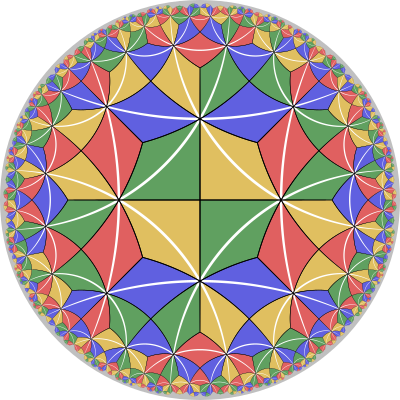

In [7]:
p1 = 4
p2 = 3
q = 3
rotate = 0
depth = 6

theta1, theta2 = math.pi*2/p1, math.pi*2/p2
phi_sum = math.pi*2/q
r1 = triangle_side_for_angles(theta1/2, phi_sum/2, theta2/2)
r2 = triangle_side_for_angles(theta2/2, phi_sum/2, theta1/2)

t_gen1 = htiles.TileGen.make_regular(p1, hr=r1, skip=1)
t_gen2 = htiles.TileGen.make_regular(p2, hr=r2, skip=1)

decorator1 = TileDecoratorFish(p1, p2, q)

t_layout = TileLayoutFish()
t_layout.add_generator(t_gen1, ((0,1)*10)[:p1], decorator1)
t_layout.add_generator(t_gen2, ((0,1,2)*10)[:p2], htiles.TileDecoratorNull())
start_tile = t_layout.start_tile(code=0,rotate_deg=-rotate)

tiles = t_layout.tile_plane(start_tile, depth=depth)

d = Drawing(2, 2, origin='center')
d.draw(euclid.Circle(0, 0, 1), fill='silver')
for tile in tiles:
    d.draw(tile, layer=0)
for tile in tiles:
    d.draw(tile, layer=1)
for tile in tiles:
    d.draw(tile, layer=2)

d.set_render_size(w=400)
d.save_svg('images/escherApprox.svg')
d.rasterize(to_file='images/escherApprox.png')

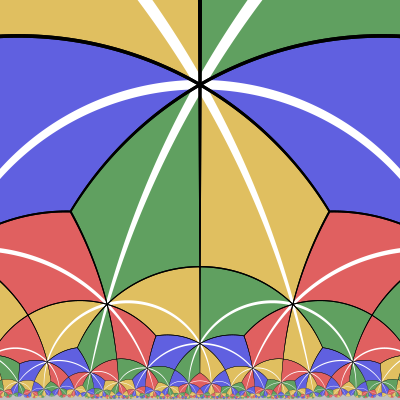

In [8]:
# Transform the Poincare disk to the Poincare half-plane
# A small translation to avoid singularities
trans = Transform.merge(
    Transform.mirror((1, 0)),
    Transform.disk_to_half(),
    Transform.translation((-0.00001,0)),
    Transform.mirror((1, 0)),
)

d = Drawing(3, 3, origin=(-1.5, -3))
d.append(draw.Rectangle(-10, -10, 20, 20, fill='silver'))
for tile in tiles:
    d.draw(tile, transform=trans, layer=0)
for tile in tiles:
    d.draw(tile, transform=trans, layer=1)
for tile in tiles:
    d.draw(tile, transform=trans, layer=2)

d.set_render_size(w=400)
d.save_svg('images/escherApproxHalfPlane.svg')
d.rasterize(to_file='images/escherApproxHalfPlane.png')